In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from properscoring import crps_ensemble
import random


sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, plot_pnn_preds, plot_prop_pnn_preds
D = 40
M = 50
T = 10

start_year = 2013
end_year = 2023
data_split = [0.7, 0.15, 0.15]
seed = 123

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)


In [2]:
# Create serotype obj
denv_df = pd.read_csv(project_dir / "data" / "transformed" / "denv_df.csv")
sero_props = pd.read_csv(project_dir / "data" / "transformed" / "sero_props.csv")

denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date']).dt.to_period('M')
denv_df['Submission date'] = pd.to_datetime(denv_df['Submission date']).dt.to_period('M')
sero_props['Collection date'] = pd.to_datetime(sero_props['Collection date']).dt.to_period('M')
sero_dataset = SeroDataset(dataset=denv_df, prop_dataset=sero_props, T=T)

In [3]:
# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M)
true_count_dataset = TrueCountDataset(delays_df)


In [4]:
# End of 2023 appears to have some incomplete data

dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
data_split_sizes = (np.array(data_split) * len(dates)).astype(int)

# Ensure dates line up fully, also removing 2023-12-31 as doesn't appear complete
data_split_sizes[-1] = len(dates) - data_split_sizes[:-1].sum()


train_dates = dates[:data_split_sizes[0]]
val_dates = dates[data_split_sizes[0]:data_split_sizes[0]+data_split_sizes[1]]
test_dates = dates[data_split_sizes[0]+data_split_sizes[1]:]


In [5]:
class PNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        y = self.true_count_obj.get_y(date)
        dow = date.day_of_week
        return (obs, dow), y
    
train_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_pnn_dataset, batch_size=32, shuffle=False)


In [6]:
pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
pnn_train = BaseTrain("PNN")
pnn_train.train_model(pnn_model, train_loader, val_loader)

KeyboardInterrupt: 

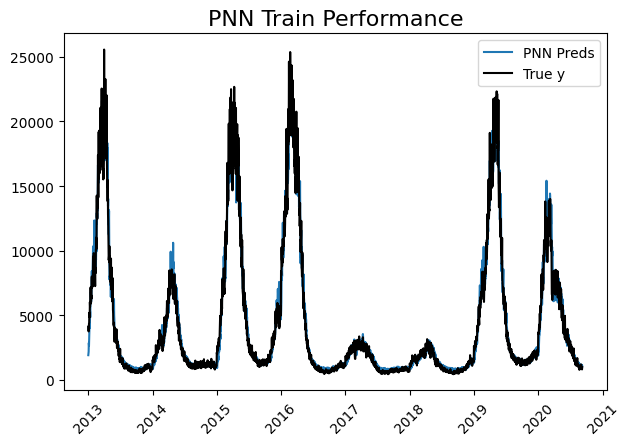

CRPS: 361.5774324189525


In [13]:
pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-PNN"))

pnn_train_samples, train_y_true = eval_pnn(train_pnn_dataset, pnn_model)


plot_pnn_preds(pnn_train_samples,train_pnn_dataset, "PNN Train Performance")
print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), pnn_train_samples).mean()}")

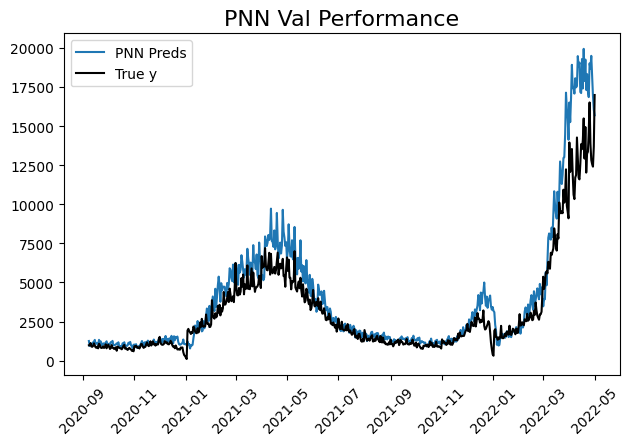

CRPS: 664.7705850249583


In [14]:
pnn_val_samples, val_y_true = eval_pnn(val_pnn_dataset, pnn_model)
plot_pnn_preds(pnn_val_samples,val_pnn_dataset, "PNN Val Performance")
print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), pnn_val_samples).mean()}")

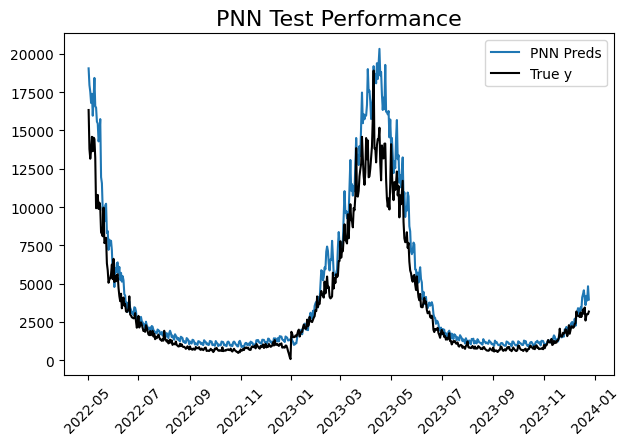

CRPS: 696.3907456053066


In [16]:
pnn_test_samples, test_y_true = eval_pnn(test_pnn_dataset, pnn_model)
plot_pnn_preds(pnn_test_samples,test_pnn_dataset, "PNN Test Performance")
print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), pnn_test_samples).mean()}")

In [6]:
class PropPNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        z = self.true_count_obj.get_z(date)
        dow = date.day_of_week
        return (obs, dow), z
    
train_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_prop_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_prop_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_prop_pnn_dataset, batch_size=32, shuffle=False)


In [11]:
prop_pnn_model = PropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
prop_pnn_train = BaseTrain("PropPNN")
prop_pnn_train.train_model(prop_pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 7.1e+03 - Val loss: 8.19e+04 - ES count: 0
Epoch 2 - Train loss: 3.89e+03 - Val loss: 4.96e+04 - ES count: 0
Epoch 3 - Train loss: 3.09e+03 - Val loss: 4.18e+04 - ES count: 0
Epoch 4 - Train loss: 2.66e+03 - Val loss: 3.36e+04 - ES count: 0
Epoch 5 - Train loss: 2.23e+03 - Val loss: 2.15e+04 - ES count: 0
Epoch 6 - Train loss: 1.98e+03 - Val loss: 1.96e+04 - ES count: 0
Epoch 7 - Train loss: 1.84e+03 - Val loss: 2.16e+04 - ES count: 1
Epoch 8 - Train loss: 1.77e+03 - Val loss: 2.22e+04 - ES count: 2
Epoch 9 - Train loss: 1.63e+03 - Val loss: 1.43e+04 - ES count: 0
Epoch 10 - Train loss: 1.64e+03 - Val loss: 1.68e+04 - ES count: 1
Epoch 11 - Train loss: 1.5e+03 - Val loss: 1.58e+04 - ES count: 2
Epoch 12 - Train loss: 1.45e+03 - Val loss: 1.19e+04 - ES count: 0
Epoch 13 - Train loss: 1.37e+03 - Val loss: 9.99e+03 - ES count: 0
Epoch 14 - Train loss: 1.29e+03 - Val loss: 1.23e+04 - ES count: 1
Epoch 15 - Train loss: 1.22e+03 - Val loss: 1.18e+04 - ES count: 2
Epoch 

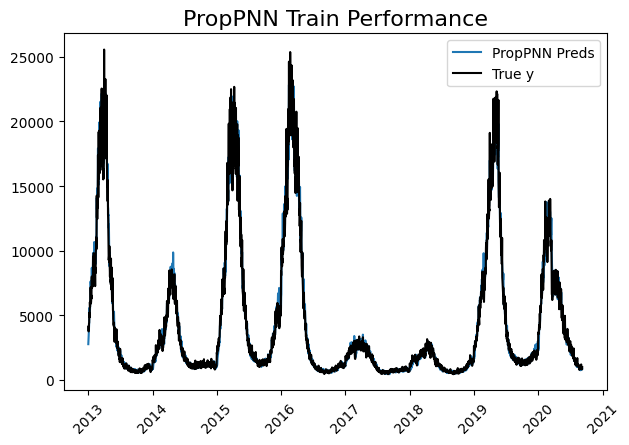

CRPS: 249.10884047025294


In [7]:
prop_pnn_model = PropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
prop_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-PropPNN"))

prop_pnn_train_samples, train_z_true = eval_prop_pnn(train_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_train_samples,train_prop_pnn_dataset, "PropPNN Train Performance")

train_y_true = train_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), prop_pnn_train_samples).mean()}")

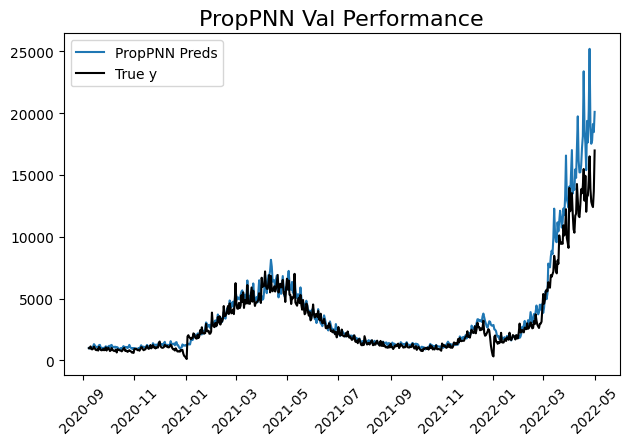

CRPS: 466.66973311148087


In [9]:
prop_pnn_val_samples, val_z_true = eval_prop_pnn(val_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_val_samples,val_prop_pnn_dataset, "PropPNN Val Performance")

val_y_true = val_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), prop_pnn_val_samples).mean()}")

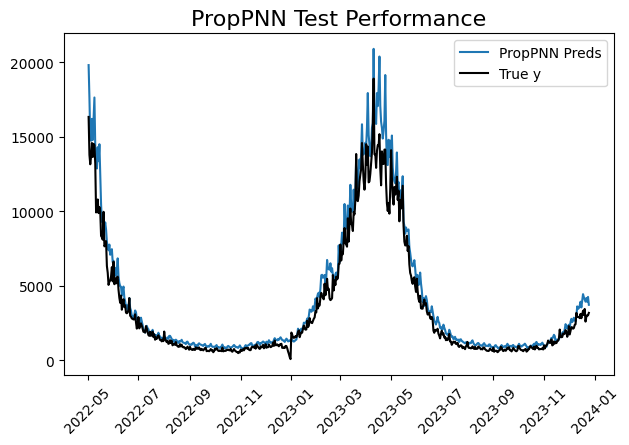

CRPS: 496.7022593698174


In [10]:
prop_pnn_test_samples, test_z_true = eval_prop_pnn(test_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_test_samples,test_prop_pnn_dataset, "PropPNN Test Performance")

test_y_true = test_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), prop_pnn_test_samples).mean()}")

In [7]:
sparse_prop_pnn_model = SparsePropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sparse_prop_pnn_train = SparsePropTrain("SparsePropPNN")
sparse_prop_pnn_train.train_model(sparse_prop_pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 1.87e+05 - Val loss: 2.19e+06 - ES count: 0
Epoch 2 - Train loss: 1.04e+05 - Val loss: 1.65e+06 - ES count: 0
Epoch 3 - Train loss: 9.41e+04 - Val loss: 1.52e+06 - ES count: 0
Epoch 4 - Train loss: 8.62e+04 - Val loss: 1.1e+06 - ES count: 0
Epoch 5 - Train loss: 7.47e+04 - Val loss: 1.48e+06 - ES count: 1
Epoch 6 - Train loss: 8.08e+04 - Val loss: 1.02e+06 - ES count: 0
Epoch 7 - Train loss: 6.38e+04 - Val loss: 1.02e+06 - ES count: 0
Epoch 8 - Train loss: 6.15e+04 - Val loss: 8.7e+05 - ES count: 0
Epoch 9 - Train loss: 5.97e+04 - Val loss: 7.51e+05 - ES count: 0
Epoch 10 - Train loss: 5.41e+04 - Val loss: 7.25e+05 - ES count: 0
Epoch 11 - Train loss: 5.27e+04 - Val loss: 7.03e+05 - ES count: 0
Epoch 12 - Train loss: 4.91e+04 - Val loss: 8.65e+05 - ES count: 1
Epoch 13 - Train loss: 5.73e+04 - Val loss: 9.29e+05 - ES count: 2
Epoch 14 - Train loss: 5.44e+04 - Val loss: 6.05e+05 - ES count: 0
Epoch 15 - Train loss: 4.63e+04 - Val loss: 4.63e+05 - ES count: 0
Epoch 

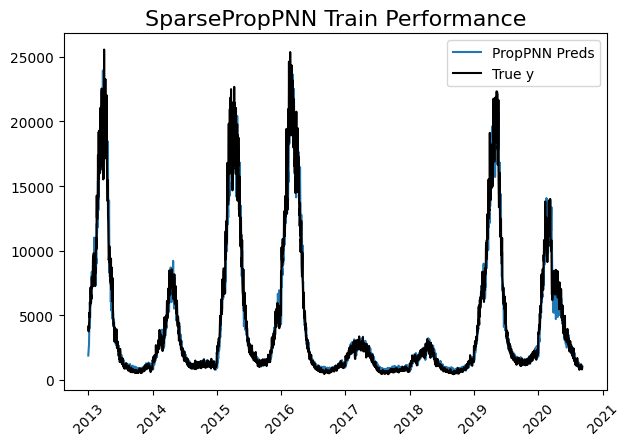

CRPS: 351.54345279658


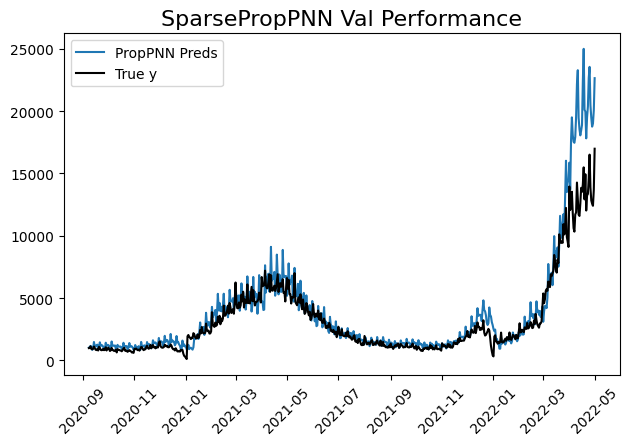

CRPS: 602.1722808652246


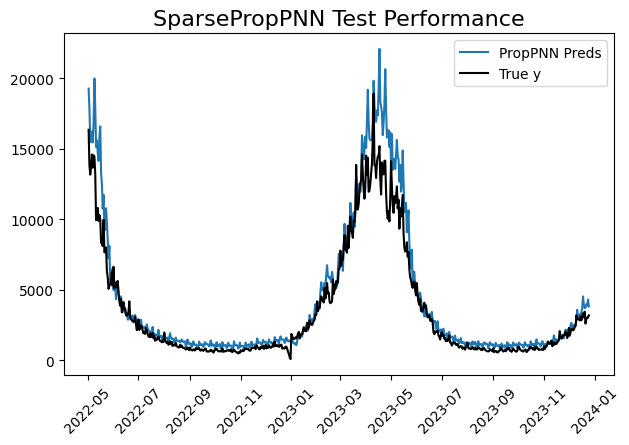

CRPS: 588.2432882255389


In [7]:
sparse_prop_pnn_model = SparsePropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sparse_prop_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-SparsePropPNN"))

sparse_prop_pnn_train_samples, train_z_true = eval_sparse_prop_pnn(train_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_train_samples,train_prop_pnn_dataset, "SparsePropPNN Train Performance")

train_y_true = train_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), sparse_prop_pnn_train_samples).mean()}")

sparse_prop_pnn_val_samples, val_z_true = eval_sparse_prop_pnn(val_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_val_samples,val_prop_pnn_dataset, "SparsePropPNN Val Performance")

val_y_true = val_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), sparse_prop_pnn_val_samples).mean()}")

sparse_prop_pnn_test_samples, test_z_true = eval_sparse_prop_pnn(test_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_test_samples,test_prop_pnn_dataset, "SparsePropPNN Test Performance")

test_y_true = test_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), sparse_prop_pnn_test_samples).mean()}")